# Double integrator - energy minimisation - state constraint

The consumption minimisation with control constraint double integrator problem consists in minimising

$$
    0.5\int_{0}^{1} {u(t)}^2 \, \mathrm{d}t
$$

subject to the constraints

$$
    \dot x_1(t) = x_2(t), \quad \dot x_2(t) = u(t), \quad u(t) \in \R, \quad x_1(t) \leq l
$$

and the limit conditions

$$
    x(0) = (0,1), \quad x(1) = (0,-1).
$$

## Direct method

In [12]:
# For direct methods
using JuMP, Ipopt
# To plot solutions
using Plots

In [21]:
# Create JuMP model, using Ipopt as the solver
sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 5))
set_optimizer_attribute(sys,"tol",1e-8)
set_optimizer_attribute(sys,"constr_viol_tol",1e-6)
set_optimizer_attribute(sys,"max_iter",1000)

# Parameters
l = 1/9
t0 = 0    # initial time
tf = 1    # final time
c0 = 0    # Initial cost
x0 = [0, 1]    # Initial position
xf = [0, -1]   # Final position

N  = 500    # Grid size
Δt = (tf-t0)/N  # Time step

@variables(sys, begin
    c[1:N+1]        # Cost
    x1[1:N+1] ≤ l   # Position
    x2[1:N+1]       # Velocity
    u[1:N+1]        # Control
end)

# Objective
@objective(sys, Min, 0.5*c[N+1])

# Boundary constraints
@constraints(sys, begin
    con_c0, c[1] - c0 == 0
    con_x01, x1[1] - x0[1] == 0
    con_x02, x2[1] - x0[2] == 0
    con_xf1, x1[N+1] - xf[1] == 0
    con_xf2, x2[N+1] - xf[2] == 0
end)

# Dynamics with Crank-Nicolson scheme
@NLconstraints(sys, begin
    con_dc[j=1:N],  c[j+1]  == c[j]  + 0.5 * Δt * (u[j+1]^2 + u[j]^2)
    con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (x2[j+1]  + x2[j] )
    con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * ( u[j+1]  +  u[j] )
end);

In [22]:
# Solve for the control and state
println("Solving...")
optimize!(sys)
println()

# Display results
if termination_status(sys) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(sys))
println()

# Retrieves values (including duals)
c  = value.(c)[:]
x1 = value.(x1)[:]
x2 = value.(x2)[:]
u  = value.(u)[:]
t  = (0:N) * value.(Δt)

pc0 = dual(con_c0)
px01 = dual(con_x01)
px02 = dual(con_x02)
pxf1 = dual(con_xf1)
pxf2 = dual(con_xf2)

if(pc0*dual(con_dc[1])<0); pc0 = -pc0; end
if(px01*dual(con_dx1[1])<0); px01 = -px01; end
if(px02*dual(con_dx2[1])<0); px02 = -px02; end
if(pxf1*dual(con_dx1[N])<0); pxf1 = -pxf1; end
if(pxf2*dual(con_dx2[N])<0); pxf2 = -pxf2; end

if (pc0 > 0) # Sign convention according to Pontryagin Maximum Principle
    sign = -1.0
else
    sign =  1.0
end

pc  = [ dual(con_dc[i])  for i in 1:N ]
px1 = [ dual(con_dx1[i]) for i in 1:N ]
px2 = [ dual(con_dx2[i]) for i in 1:N ]

pc  = sign * [pc0; pc[1:N]] 
px1 = sign * [px01; (px1[1:N-1]+px1[2:N])/2; pxf1]
px2 = sign * [px02; (px2[1:N-1]+px2[2:N])/2; pxf2];

Solving...


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:     6005
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:     2004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:      501
Total number of equality constraints.................:     1505
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 8.09e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

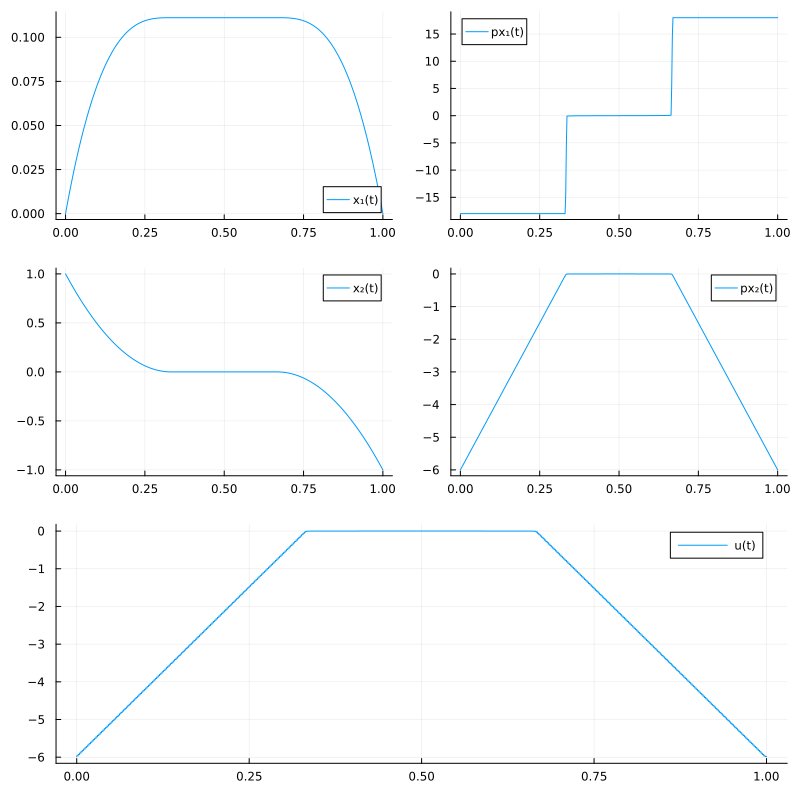

In [23]:
x1_plot = plot(t, x1, label="x₁(t)")
px1_plot = plot(t, px1, label="px₁(t)")
x2_plot = plot(t, x2, label="x₂(t)")
px2_plot = plot(t, px2, label="px₂(t)")
u_plot = plot(t, u, label="u(t)", linetype=:steppre)

pxp_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, layout=(2,2))
l = @layout [a{0.66h}
            b]
plot(pxp_plot, u_plot, layout=l, size=(800,800))